## Clustering
In this notebook, we try to cluster the locations(latitude,longitude) based on the weather measurements, and then check whether the clustering make sense or not based on their geography(latitude, longitude, elevation)

Monthly smoothed data is used here as it has much less noise and can be very well explained by its eigen decomposition. More details is in notebook '4.4 Weather Analysis - Visualisation-monthly'

And further more, we reduce the 12 dimension vector(12 months) to 3 eigen coefficients for each data sample, as we saw in 4.4 notebook that top 3 eigen vectors can represent 80% variance of original 12 dimension dataset.

So the clustering we finally found reflects more general similarity between locations in yearly basis.

In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSBBB'

## Load the required libraries

In [ ]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from leaflet import *

In [2]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [3]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File and monthly average data

In [4]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_monthly_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))

# Read data file into a spark DataFrame
filename=data_dir+'/US_Weather_monthly_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)

In [115]:
with open(data_dir+'/stations.pkl','rb') as file:
    Stations=load(file)
print Stations.shape
Stations.head()

(85284, 8)


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


## Process whole data set with eigen decomposition
### Add to each row in the dataframe 3 eigen coefficients 
`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [5]:
def decompose(row, mean=None, v=None):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [6]:
from functools import partial

k=4

df_all = {}
for m in STAT.keys():
    df=df_in.filter(df_in.measurement==m)

    EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
    Mean=STAT[m]['Mean']
    v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

    rdd2=df.rdd.map(partial(decompose, mean=Mean, v=v))
    df2=sqlContext.createDataFrame(rdd2)
    df3=df2.filter(df2.res_mean<1)
    # Sort entries by increasing values of ers_3
    #df3=df3.sort(df3.res_3,ascending=True)
    df_all[m] = df3
    sqlContext.registerDataFrameAsTable(df3,'weather_%s'%(m)) #using older sqlContext instead of newer (V2.0) sparkSession


In [7]:
df_all['TMIN'].take(1)

[Row(coeff_1=-87.88699972935609, coeff_2=26.826168262201755, coeff_3=3.0644293891956673, coeff_4=-12.098336479735648, elevation=1340.2, label=u'SSSBSBBB', latitude=39.5236, longitude=-119.7386, measurement=u'TMIN', res_1=0.2311279181338304, res_2=0.15949343979228026, res_3=0.1585586713299319, res_4=0.1439887860597298, res_mean=0.14454546189937156, station=u'USC00267693', total_var=69500.9474029541, undefs=17, vector=bytearray(b'k\xd2\xa7\xcf\x07\xcd\xa5P\xefR\x1eW\xd6X\xa0W\x96U\x87N\xa5\xc5\xf2\xcd'), year=2002.0)]

In [29]:
df_merged = reduce(DataFrame.unionAll, df_all.values())
# check total valid data samples
df_merged.count()

### Clustering based on one feature(measurement)
SNWD is first choice since its eigenvector has most explaination power

In [188]:
meas = 'PRCP'
pdf = df_all[meas].toPandas()
data_pivot = pdf[['station','year','coeff_1','coeff_2','coeff_3']].set_index(['station','year']).unstack()

In [189]:
data_pivot.count(axis=1)

station
US1CANV0001      9
US1CANV0004      9
US1CAPC0001     12
US1NVWH0003      6
US1NVWH0019      6
US1NVWH0025      3
US1NVWH0035      3
US1NVWH0059      6
USC00040747     30
USC00040931    183
USC00041018    219
USC00041462    132
USC00041768     51
USC00041912    246
USC00042334    129
USC00042338     60
USC00042467    159
USC00042500    249
USC00043491    216
USC00044288    207
USC00044713    219
USC00044773     69
USC00045088      3
USC00045171     18
USC00046136    318
USC00047085    171
USC00047088      3
USC00047641    129
USC00048207     93
USC00048218    201
              ... 
USC00049043    231
USC00049351     60
USC00260507     30
USC00261485     54
USC00262708      9
USC00263420      3
USC00264542     78
USC00264858     75
USC00265440     21
USC00265441      3
USC00265445      9
USC00265447      6
USC00267710      6
USC00267820     12
USC00268761     51
USS0015K03S     33
USS0017K04S     48
USS0019K04S     57
USS0019K07S     48
USS0019K08S     42
USS0020K03S     48
USS0

In [191]:
station, feature = data_pivot.shape
print station,feature
# drop columns(measure) that have valid entry < 10
# drop rows(station) that have valid entry < 0.7*station
data_left1 = data_pivot.dropna(thresh=80)
print data_left1.shape
data_left2 = data_left1.dropna(axis=1, thresh=15)
data_left2.shape

66 363
(18, 363)


(18, 75)

In [192]:
# now we have a much smaller dataset, but with much less NaN
data_left2

coeff_1                                                 \
year             1950.0      1954.0      1955.0     1956.0      1958.0   
station                                                                  
USC00040931   26.949758  -23.533454   -1.488265 -27.763287  -16.463200   
USC00041018   83.325289   79.521027   35.063187        NaN         NaN   
USC00041462  120.665656   60.938893   59.718604  60.129375   87.506460   
USC00041912  107.897912   54.251610   41.954001  18.175918   59.810900   
USC00042334  157.214958   56.008042   75.985609  53.972276  131.352810   
USC00042467         NaN   37.419697   22.779441  13.636981   19.591087   
USC00042500  170.299779   86.809659   72.972251  77.982353  109.274312   
USC00043491  142.475541   70.438245   61.308298  35.513956  112.060545   
USC00044288  108.472171   69.777192   75.203018  44.825179  100.657645   
USC00044713  141.411880   70.159942   70.136364  69.639982  133.236188   
USC00046136  105.355189   70.342771   33.806971  48.946177   90.915156   
USC00047085   11.028911  -18.652302  -28.933161 -33.917021  -16.276139   
USC00047641         NaN   15.831208   10.851925        NaN   34.413519   
USC00048207  153.094639  103.642305         NaN        NaN   95.316091   
USC00048218   26.264018   -1.281587  -32.558262 -23.666323  -13.646551   
USC00048758   62.208852    9.022503   17.209036  -2.628702    4.038539   
USC00049043   75.404393   17.821053    3.778975   1.400238   16.173405   
USW00023225  141.319189   84.225198  101.356696  90.347193  125.546774   

                                                                      \
year            1959.0      1960.0     1962.0     1963.0      1964.0   
station                                                                
USC00040931        NaN  -24.538165 -15.225174  -5.759425   -9.022355   
USC00041018        NaN   48.744566  79.651581  43.115402  101.919923   
USC00041462  24.681665   74.126426  53.135291  11.227201   29.732847   
USC00041912  21.448151   52.285632  56.458797  18.822112   62.847324   
USC00042334  34.257589  118.679628  57.861818  36.642385  124.616212   
USC00042467   4.534805   31.257406  49.824323   8.576279         NaN   
USC00042500  55.801570  105.011711  82.977465  33.618003   27.416437   
USC00043491  32.797381   81.651219  65.229963  25.160640   83.898464   
USC00044288  29.759320   74.068527        NaN        NaN   69.574343   
USC00044713  35.535409  103.979415  71.541577  67.630849   99.431325   
USC00046136  49.579375   60.631567  43.312839  14.207603   54.597784   
USC00047085 -27.254032  -15.883110 -13.956904 -23.243471  -10.822167   
USC00047641 -37.443057         NaN  14.510912  -1.410392   14.797564   
USC00048207  30.234608   83.187926        NaN        NaN         NaN   
USC00048218 -28.214360  -19.686377  -5.529468  -4.913234   -9.914378   
USC00048758 -14.431937    8.254204  20.122642  -6.563625   28.409325   
USC00049043  -7.257463   -0.303284  22.265845   1.953133   16.461777   
USW00023225  48.278863  103.602052  61.163828  57.360768  112.609607   

               ...         coeff_3                                   \
year           ...          1970.0     1971.0     1972.0     1974.0   
station        ...                                                    
USC00040931    ...      -44.363638  -4.428545   6.899918  -4.740725   
USC00041018    ...      -54.959357  10.703034  35.279144 -26.787664   
USC00041462    ...      -69.986592   9.295613        NaN        NaN   
USC00041912    ...      -50.281476  13.560134  26.407752  -3.221042   
USC00042334    ...             NaN        NaN        NaN        NaN   
USC00042467    ...      -59.256730  10.571490  17.096681 -12.443655   
USC00042500    ...     -101.301445  -6.031349  20.599593   6.266989   
USC00043491    ...      -40.246085   4.409930  31.819166  -6.336957   
USC00044288    ...      -57.901678  10.084220  25.884873   2.545807   
USC00044713    ...      -80.561019   6.178678  26.696015 -23.022324   
USC00046136    ...      -

In [193]:
# fill NaN with median
for col in data_left2.columns.values:
    med = data_left2[col].median()
    data_left2[col] = data_left2[col].fillna(med)

c:\Users\wenyan\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [198]:
from sklearn.cluster import KMeans

# choose best model param: n_clusters=3, n_init=5
k_means = KMeans(n_clusters=4, n_init=5, init='k-means++', random_state=5) 
k_means.fit(data_left2)
k_means.labels_

data_map = data_left2.join(Stations,how='left')
data_map['label'] = k_means.labels_
data_map.head(5)

,"(coeff_1, 1950.0)","(coeff_1, 1954.0)","(coeff_1, 1955.0)","(coeff_1, 1956.0)","(coeff_1, 1958.0)","(coeff_1, 1959.0)","(coeff_1, 1960.0)","(coeff_1, 1962.0)","(coeff_1, 1963.0)","(coeff_1, 1964.0)",...,"(coeff_3, 1986.0)",latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID,label
station,,,,,,,,,,,,,,,,,,,,,
USC00040931,26.949758,-23.533454,-1.488265,-27.763287,-16.46320,27.220493,-24.538165,-15.225174,-5.759425,-9.022355,...,28.377620,39.3886,-120.0936,1699.3,A,BOCA,NaN,NaN,NaN,3
USC00041018,83.325289,79.521027,35.063187,35.513956,87.50646,27.220493,48.744566,79.651581,43.115402,101.919923,...,8.279441,39.4539,-120.6556,1641.3,A,BOWMAN DAM,NaN,NaN,NaN,0
USC00041462,120.665656,60.938893,59.718604,60.129375,87.50646,24.681665,74.126426,53.135291,11.227201,29.732847,...,6.480958,39.4500,-121.0500,839.7,A,CAMPTONVILLE RS,NaN,NaN,NaN,2
USC00041912,107.897912,54.251610,41.954001,18.175918,59.81090,21.448151,52.285632,56.458797,18.822112,62.847324,...,15.185578,39.0911,-120.9481,725.4,A,COLFAX,NaN,HCN,NaN,2
USC00042334,157.214958,56.008042,75.985609,53.972276,131.35281,34.257589,118.679628,57.861818,36.642385,124.616212,...,6.480958,39.3000,-120.8500,1129.0,A,DEER CREEK PH,NaN,NaN,NaN,2


In [199]:
    scope_max=data_map.max()
    scope_min=data_map.min()
    min_lat,max_lat,min_long,max_long = box = (scope_min['latitude'], scope_max['latitude'], scope_min['longitude'], scope_max['longitude'])

    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF']
    center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
    zoom = 7
    lat_margin=(max_lat-min_lat)/4
    long_margin=(max_long-min_long)/4
    m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
    r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
    m += r

    k=0
    for index,row in data_map.iterrows():
        _lat=row['latitude']
        _long=row['longitude']
        _label = row['label']
        r = row['elevation']
        #r=abs(row['inertia'])/5
        color=colors[_label]
        c = Circle(location=(_lat,_long), radius=int(r), weight=1,
                color=color, opacity=0.3, fill_opacity=0.6, fill_color=color)
        m += c
    m    

In [24]:
from sklearn.cluster import KMeans

def plot_knn_cluster(X):
    plt.clf()
    n_list = np.arange(1,30,1)
    inertia = []
    for n in n_list: 
        k_means = KMeans(n_clusters=n, init='k-means++') 
        k_means.fit(X)
        inertia.append(k_means.inertia_)
    plt.plot(n_list, inertia)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

def plot_knn_ninit(X, cluster):
    plt.clf()
    n_list = np.arange(1,30,1)
    inertia = []
    for n in n_list: 
        k_means = KMeans(n_clusters=cluster, init='k-means++') 
        k_means.fit(X)
        inertia.append(k_means.inertia_)
    plt.plot(n_list, inertia)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

### Clustering based on all measurements
We want to select samples of (year,station) pair that we have any of 4 measurements in the year for the station.

Basically, we outer join the 4 measurement tables on having same year and station

In [8]:
query = 'SELECT '
columns = []
tables = ['TMIN','TMAX','SNOW','PRCP']
#tables = ['TMIN','PRCP']
for m in tables:
    query += '%s.year %s_year,%s.station %s_station,' % (m,m,m,m)
    columns.append("%s.coeff_1 %s_c1,%s.coeff_2 %s_c2,%s.coeff_3 %s_c3" % (m,m,m,m,m,m))
query += ','.join(columns)
query += "\nFROM weather_%s as %s " %(tables[0], tables[0])
for m in tables[1:]:
    query += '\nFULL OUTER JOIN weather_%s as %s ON %s.station=%s.station AND %s.year=%s.year ' %(m,m,tables[0],m,tables[0],m)
print query
df_join1 = sqlContext.sql(query)

SELECT TMIN.year TMIN_year,TMIN.station TMIN_station,TMAX.year TMAX_year,TMAX.station TMAX_station,SNOW.year SNOW_year,SNOW.station SNOW_station,PRCP.year PRCP_year,PRCP.station PRCP_station,TMIN.coeff_1 TMIN_c1,TMIN.coeff_2 TMIN_c2,TMIN.coeff_3 TMIN_c3,TMAX.coeff_1 TMAX_c1,TMAX.coeff_2 TMAX_c2,TMAX.coeff_3 TMAX_c3,SNOW.coeff_1 SNOW_c1,SNOW.coeff_2 SNOW_c2,SNOW.coeff_3 SNOW_c3,PRCP.coeff_1 PRCP_c1,PRCP.coeff_2 PRCP_c2,PRCP.coeff_3 PRCP_c3
FROM weather_TMIN as TMIN 
FULL OUTER JOIN weather_TMAX as TMAX ON TMIN.station=TMAX.station AND TMIN.year=TMAX.year 
FULL OUTER JOIN weather_SNOW as SNOW ON TMIN.station=SNOW.station AND TMIN.year=SNOW.year 
FULL OUTER JOIN weather_PRCP as PRCP ON TMIN.station=PRCP.station AND TMIN.year=PRCP.year 


In [9]:
data_join1 = df_join1.toPandas()
data_join1['station'] = data_join1.apply(lambda row:  row['TMIN_station'] or row['TMAX_station'] or row['PRCP_station'] or row['SNOW_station'], axis=1)
data_join1['year'] = data_join1.apply(lambda row:  row['TMIN_year'] or row['TMAX_year'] or row['PRCP_year'] or row['SNOW_year'], axis=1)
data_join2 = data_join1.drop(['TMIN_year','TMIN_station','TMAX_year','TMAX_station','SNOW_year','SNOW_station','PRCP_year','PRCP_station'],axis=1)

In [11]:
data_join3 = data_join2[np.isfinite(data_join2['year'])]

In [12]:
#data_join1
data_pivot = data_join3.set_index(['station','year']).unstack()
data_pivot.shape

(102, 1500)

### trim the sparse matrix
Outer join gives us a matrix of 102 stations x 1500 measures, which has a lot of Nan value. Well, clustering model like KNN require no position has NaN. So we have to drop columns or rows that have too many missing values and fill reasonable amount of missing value with media of according column.

Again, the goal is to find out the clustering btw stations, so we have 2 tries:
* 1st is to keep as many features as possible, this will result in fewer stations.
* 2nd is to keep stations as possible, but this will dramatically reduce our available features.

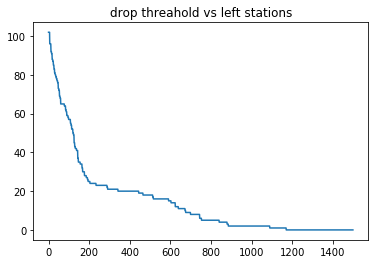

In [13]:
left_station_count = []
for i in range(1, data_pivot.shape[1]):
    data_keep_meas = data_pivot.dropna(thresh=i)
    left_station_count.append(data_keep_meas.shape[0])
plt.plot(left_station_count)
plt.title("drop threahold vs left stations")

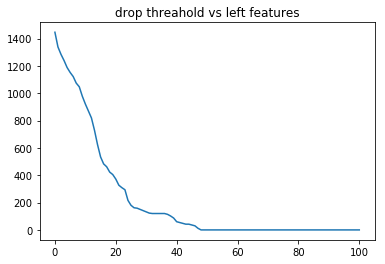

In [14]:
left_feature_count = []
for i in range(1, data_pivot.shape[0]):
    data_keep_station = data_pivot.dropna(axis=1, thresh=i)
    left_feature_count.append(data_keep_station.shape[1])
plt.plot(left_feature_count)
plt.title("drop threahold vs left features")

In [15]:
data_final_keep_feature = data_pivot.dropna(thresh=300)
data_final_keep_feature.shape

(21, 1500)

In [16]:
data_final_keep_station = data_pivot.dropna(axis=1, thresh=47)
data_final_keep_station.shape

(102, 30)

In [87]:
# mixed selection
# drop columns(measure) that have valid entry < 30
# drop rows(station) that have valid entry < 100
data_final1 = data_pivot.dropna(axis=1, thresh=30)
print data_final1.shape
data_final2 = data_final1.dropna(thresh=100)
data_final2.shape

(102, 141)


(32, 141)

In [88]:
for col in data_final2.columns.values:
    med = data_final2[col].median()
    data_final2[col] = data_final2[col].fillna(med)

c:\Users\wenyan\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [89]:
data_final2[:5]

TMIN_c1                                                  \
year             1989.0      1990.0      1991.0      1992.0      1993.0   
station                                                                   
USC00040931  209.801690  252.939898  219.884449  214.570483  214.013900   
USC00041912 -211.463766 -207.545218 -204.777512 -227.984752 -193.509014   
USC00042467  144.876311   12.776272  134.902788  107.555570  133.422061   
USC00042500  -43.826578  -37.340134  -51.927382  -88.183583  -65.957425   
USC00046136 -187.922451 -180.919943 -201.036943 -185.052540 -190.329274   

                                                                         \
year             1994.0      1995.0      1996.0      1997.0      1998.0   
station                                                                   
USC00040931   14.464993  166.642541  144.027994   30.361274   50.852775   
USC00041912 -189.812914 -204.702932   14.835563 -201.708388 -188.497925   
USC00042467  139.953385  107.225813   89.802408  101.011191  100.050234   
USC00042500  -50.188467  -82.713745  -92.771493  -89.692273  -82.720859   
USC00046136 -184.596408 -207.439076 -214.974654 -203.442932 -177.152362   

               ...       TMAX_c3                                              \
year           ...        2003.0     2004.0     2005.0     2006.0     2007.0   
station        ...                                                             
USC00040931    ...      1.239311 -23.255994  25.735602  21.770643 -13.177514   
USC00041912    ...    -17.563430 -38.808747  34.010346   8.153409 -46.979508   
USC00042467    ...    -17.755581 -27.211336  13.350240  11.887608  -5.621277   
USC00042500    ...     -5.266590 -26.567612   0.797163  11.374473 -61.446969   
USC00046136    ...    -24.461945 -40.242602 -17.964145   4.151481 -53.402894   

                                                                   
year            2008.0      2009.0    2010.0     2011.0    2012.0  
station                                                            
USC00040931  47.821591    4.447288  4.795222  45.615353  8.311337  
USC00041912  21.281040 -105.808143  0.564532   9.094422 -4.506196  
USC00042467  36.964847    3.965941  0.564532  62.896975 -3.322063  
USC00042500  36.456871   -9.596413 -2.002296  18.190498 -4.623360  
USC00046136  17.720808  -30.996381 -9.408872   7.715503 -4.623360  

[5 rows x 141 columns]

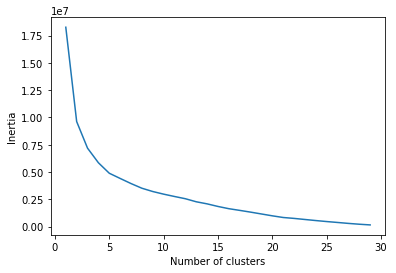

In [90]:
plot_knn_cluster(data_final2)

In [202]:
from sklearn.cluster import KMeans

# choose best model param: n_clusters=5, n_init=5
k_means = KMeans(n_clusters=5, n_init=5, init='k-means++', random_state=5) 
k_means.fit(data_final2)
k_means.labels_

array([1, 0, 1, 0, 0, 1, 1, 1, 2, 4, 2, 4, 2, 2, 2, 0, 1, 4, 4, 2, 4, 3, 3,
       3, 3, 3, 1, 1, 1, 3, 2, 2])

In [203]:
data_map = data_final2.join(Stations,how='left')
data_map['label'] = k_means.labels_
data_map.head(5)

,"(TMIN_c1, 1989.0)","(TMIN_c1, 1990.0)","(TMIN_c1, 1991.0)","(TMIN_c1, 1992.0)","(TMIN_c1, 1993.0)","(TMIN_c1, 1994.0)","(TMIN_c1, 1995.0)","(TMIN_c1, 1996.0)","(TMIN_c1, 1997.0)","(TMIN_c1, 1998.0)",...,"(TMAX_c3, 2012.0)",latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID,label
station,,,,,,,,,,,,,,,,,,,,,
USC00040931,209.801690,252.939898,219.884449,214.570483,214.013900,14.464993,166.642541,144.027994,30.361274,50.852775,...,8.311337,39.3886,-120.0936,1699.3,A,BOCA,NaN,NaN,NaN,1
USC00041912,-211.463766,-207.545218,-204.777512,-227.984752,-193.509014,-189.812914,-204.702932,14.835563,-201.708388,-188.497925,...,-4.506196,39.0911,-120.9481,725.4,A,COLFAX,NaN,HCN,NaN,0
USC00042467,144.876311,12.776272,134.902788,107.555570,133.422061,139.953385,107.225813,89.802408,101.011191,100.050234,...,-3.322063,39.3239,-120.2331,1809.6,A,DONNER MEM SP,NaN,NaN,NaN,1
USC00042500,-43.826578,-37.340134,-51.927382,-88.183583,-65.957425,-50.188467,-82.713745,-92.771493,-89.692273,-82.720859,...,-4.623360,39.5633,-120.8239,888.5,A,DOWNIEVILLE,NaN,NaN,NaN,0
USC00046136,-187.922451,-180.919943,-201.036943,-185.052540,-190.329274,-184.596408,-207.439076,-214.974654,-203.442932,-177.152362,...,-4.623360,39.2467,-121.0008,847.6,A,NEVADA CITY,NaN,NaN,NaN,0


In [204]:
    scope_max=data_map.max()
    scope_min=data_map.min()
    min_lat,max_lat,min_long,max_long = box = (scope_min['latitude'], scope_max['latitude'], scope_min['longitude'], scope_max['longitude'])

    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF']
    center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
    zoom = 7
    lat_margin=(max_lat-min_lat)/4
    long_margin=(max_long-min_long)/4
    m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
    r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
    m += r

    k=0
    for index,row in data_map.iterrows():
        _lat=row['latitude']
        _long=row['longitude']
        _label = row['label']
        r = row['elevation']
        #r=abs(row['inertia'])/5
        color=colors[_label]
        c = Circle(location=(_lat,_long), radius=int(r*1.5), weight=1,
                color=color, opacity=0.3, fill_opacity=0.6, fill_color=color)
        m += c
    m    

### Conclusion
